In [1]:
#Importing packages 
import pandas as pd
import numpy as np
import scipy 
from tqdm import tqdm  #This is for creating progress bars.
import json #To save files in json format
import os #To set working directory
from datetime import datetime #To check start and end time when running code
import pickle  #To store and open previously saved machine learning models 



#Packages for language processing
import re
from collections import defaultdict
import string
import nltk
from nltk.corpus import wordnet

#Packages for visualization
import seaborn as sns
import matplotlib.pyplot as plt


# Advanced Social Data Science 2 (ASDS2) Exercises


## May 1 : Scaling

In this and the next two exercise labs, we will be working with a dataset of tweets from USA Members of Congress. The version of the dataset used today includes the 3000 most recent tweets from each member of congress. We have created a subset of this dataset containing tweets from 2018 and later, to capture only fairly recent tweets as the dataset is very large. 

Preprocessing such a large dataset takes a while to run (approx 20 mins). To save you time and effort, we have uploaded a preprocessed version of the dataset: 'MOC2021_Tweets_2018subset_preprocessed.csv'. 

The following steps were applied: 

1. Subsetting dataset to include only tweets from 2018 and later
1. Removing duplicated tweets 
2. Removing unneeded columns (all except 'nominate_name','affiliation','role','nominate_score', and 'text')
3. Turning independents into Democrats or Republicans. In essence, finding the independents ("SANDERS, Bernard" and "KING, Angus Stanley, Jr.") and turning these to "Democrat". 
4. Replace "&" with "and"
5. Remove odd special characters ("┻","┃","━","┳","┓","┏","┛","┗")
6. There are some annoying cases in these data where a character that looks like a space is not a space. Here, we just replace that character with an actual space. Note that the first "space" is not actually a space. " " == " " is FALSE. Replace "\u202F", "\u2069", "\u200d", and "\u2066" with " ".
7. Removing "RT" and "via"
8. Removing mentions (@someone)
9. Removing numbers, removing punctuation (except hyphens), removing separators, removing urls, lowercasing, removing stopwords, and lemmatizing.

In [7]:
#Setting up data paths

notebook_path = os.path.realpath(os.curdir)

path_to_moc_data = os.path.join(notebook_path, "../dataset/MOC2021_Tweets_2018subset_preprocessed.csv.bz2")

path_to_corp = os.path.join(notebook_path,"../dataset/Wordfish models/MOCscalingresults.sav")
path_to_wf_scaler = os.path.join(notebook_path,"../dataset/Wordfish models/MOCscaler.sav")


### 1: Formatting the dataset to a shape accepted by the scaler

Import the dataset with preprocessed text 'MOC2021_Tweets_2018subset_preprocessed.csv'.

The dataset includes the name of each member of Congress (nominate_name), their affiliation (Democrat or Republican), their institutional role in Congress (House or Senate), their ideological score based on how they vote in Congress (nominate_score) and the text of each of their most recent 3000 tweets, reaching back until the beginning of 2018, in original and preprocessed format. 

1. The goal of our wordfish scaling today is to give each politician an ideological score based on their tweets. To prepare the data, we therefore need to aggregate all text per politician. In essence, transform the dataframe so that each row has one politician (rather than one tweet) and each text field includes all tweets from this politician in one long string. 

Hint for 1.1: When preprocessing, some tweet text was removed (e.g. if they were only URLs). To aggregate text, you may need to replace NaN values with an empty string. Next, the pandas functions `groupby` and `agg` can help you. These steps are the same as last week. 


2. The wordfish scaler accepts data in the shape of a list of tuples containing the document name and the document text. Essentially that means that you should create a list in the format: [(politician1, preprocessed_text1), (politician2, preprocessed_text2), (politician3, preprocessed_text3)].


In [8]:
#Importing the data 
tweets_agg = pd.read_csv(path_to_moc_data, compression = 'bz2')

#Removing unnamed columns
tweets_agg = tweets_agg.drop(labels="Unnamed: 0", axis = 1)
tweets_agg = tweets_agg.drop(labels="Unnamed: 0.1", axis = 1)

#Viewing the data and its shape
print(tweets_agg.shape)
tweets_agg.head(3)

(1743964, 6)


,nominate_name,affiliation,role,nominate_score,text,text_preprocessed
0,"BUSH, Cori",Democrat,House,-0.41,We’re all about St. Louis so you know we have ...,st louis know show day tomorrow pm ct tune maj...
1,"BUSH, Cori",Democrat,House,-0.41,314 Day is about showing your St. Louis pride ...,day show st louis pride support one another co...
2,"BUSH, Cori",Democrat,House,-0.41,Alex Garcia is married with 5 children. After...,alex garcia marry child decade living trump ad...


In [9]:
#Filling empty tweets with empty string
tweets_agg.text_preprocessed = tweets_agg.text_preprocessed.fillna('')

In [10]:
#Aggregating all tweets by each politician into one row 
tweets_agg = tweets_agg.groupby(['nominate_name','affiliation','role','nominate_score'], as_index = False).agg({'text': ' '.join, 'text_preprocessed': ' '.join})


In [11]:
#Viewing the dataframe with aggregated text
tweets_agg.head()

,nominate_name,affiliation,role,nominate_score,text,text_preprocessed
0,"ADAMS, Alma",Democrat,House,-0.466,Having some morning conversations before the h...,morning conversation holiday john lewis fighte...
1,"ADERHOLT, Robert",Republican,House,0.370,https://t.co/LGHu4bEp6F There it is folks. Pel...,folks pelosi admit impeachment last forever d...
2,"AGUILAR, Peter Rey",Democrat,House,-0.292,These are only some of the brave Inland Empire...,brave inland empire resident answer call serve...
3,"ALLEN, Rick W.",Republican,House,0.680,Congratulations to #GA12’s very own Mr. Harold...,congratulation gas mr harold quarterman lead c...
4,"ALLRED, Colin",Democrat,House,-0.437,I’m always so impressed by our local organizat...,im always impressed local organization communi...


In [12]:
#Checking the new shape of the dataframe
tweets_agg.shape

(500, 6)

In [13]:
#Creating a list of politicians and their preprocessed tweet text. 

politician_doc = list(zip(tweets_agg['nominate_name'], tweets_agg['text_preprocessed']))


In [14]:
#Viewing the first item in the list
politician_doc[0]


('ADAMS, Alma',
 'morning conversation holiday john lewis fighter bruise batter beat always come back strong know win fight well prayer family time im ready make emergency goaltender zamboni driver david ayres honorary north carolina citizen courageous win amazing selfmagazine describe personal reason co-founded bmhcaucus daughter difficult pregnancy…she try get medical help wasnt treat cesarean last minute almost die happyhanukkah hope week full joy light since north carolina confirm two covid- case want let know office focus impact coronavirus part response vote provide billion prevention vaccine research assistance small business impact virus good job far ncatfootball best luck second half aggiepride thank crowd join u mint hill morning washingtonpost wild card meet leader work tackle black maternal health crisis ncga bill house pass bipartisan hold senate majority leader mcconnell wont give vote time ditch mitch take back senate cant without cal cunningham full support ill shortly 

In [15]:
# Optional: Saving the file as json for easy access later
# with open('politician_doc.json', 'w') as f:
#    json.dump(politician_doc,f)


### 2: Scaling with Wordfish

The wordfish scaler we are using is from the implementation found here: https://github.com/umanlp/SemScale. Download the folder with the code from the github link by: Code --> Download zip. Alternatively, use git 

As this is not a (super) professional implementation, there is almost no documentation of how to use the code. Therefore, we have copied the essential parts of their `wordfish.py` code below and ask you to fill in the blanks with data from the list you have just created. 

You can check what the object `corp` contains with the following commands: 
- `corp.occurences`: See the document-feature matrix 
- `corp.vocubulary`: See the full vocabulary across documents. Numbers indicate their index in the dfm. 
- `corp.results`: See the scaling results 

The wordfish scaler takes several hours to run on the full dataset. Select a **subset of perhaps 20 politicians** to check that you have a code that works. 

#### Importing code 

Download the code from the github repository and store it somewhere on your computer. The following imports will be drawing on code in that folder. 

In [21]:
#Setting working directory to be where the SemScale code is stored 
os.chdir('../dataset/SemScale-master/')

#Scaling packages 
#from helpers import io_helper
from wfcode import corpus
from wfcode import scaler
import argparse


#### Creating a corpus object

In [22]:
#Select a subset of your list of politicians 

subset = politician_doc[:20]


In [23]:
#Setting parameters (keeping the default parameters as used in the github code)

niter = 5000      #number of iterations
lr = 0.00001      #learning rate
stopwords = None  #we've already removed stopwords


In [24]:
#Creating a corpus object

corp = corpus.Corpus(subset) #input your data in the parentheses

Loading corpus, received: 20 docs.


In [25]:
#Preprocessing data
corp.tokenize(stopwords = stopwords)

#Building the document-feature matrix
corp.build_occurrences()

2023-06-05 19:18:48 Preprocessing corpus...
2023-06-05 19:18:50 Building vocabulary...
2023-06-05 19:18:51 Building coocurrence matrix...
1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20


#### Investigating the corpus object

Check the shape of your document-feature matrix. Check the vocabulary of the corpus.


In [26]:
#Check the shape of the document-feature matrix
corp.occurrences.shape 

(20, 39385)

In [27]:
#Check the vocabulary 
corp.vocabulary

{'morning': 0,
 'conversation': 1,
 'holiday': 2,
 'john': 3,
 'lewis': 4,
 'fighter': 5,
 'bruise': 6,
 'batter': 7,
 'beat': 8,
 'always': 9,
 'come': 10,
 'back': 11,
 'strong': 12,
 'know': 13,
 'win': 14,
 'fight': 15,
 'well': 16,
 'prayer': 17,
 'family': 18,
 'time': 19,
 'ready': 20,
 'make': 21,
 'emergency': 22,
 'goaltender': 23,
 'zamboni': 24,
 'driver': 25,
 'david': 26,
 'ayres': 27,
 'honorary': 28,
 'north': 29,
 'carolina': 30,
 'citizen': 31,
 'courageous': 32,
 'amazing': 33,
 'selfmagazine': 34,
 'describe': 35,
 'personal': 36,
 'reason': 37,
 'co-founded': 38,
 'bmhcaucus': 39,
 'daughter': 40,
 'difficult': 41,
 'pregnancy…she': 42,
 'try': 43,
 'get': 44,
 'medical': 45,
 'help': 46,
 'wasnt': 47,
 'treat': 48,
 'cesarean': 49,
 'last': 50,
 'minute': 51,
 'almost': 52,
 'die': 53,
 'happyhanukkah': 54,
 'hope': 55,
 'week': 56,
 'full': 57,
 'joy': 58,
 'light': 59,
 'since': 60,
 'confirm': 61,
 'two': 62,
 'covid-': 63,
 'case': 64,
 'want': 65,
 'let': 66,

#### Training the wordfish scaler

In [28]:
wf_scaler = scaler.WordfishScaler(corp)

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " WordFish scaling begun.")

wf_scaler.initialize()
wf_scaler.train(learning_rate = lr, num_iters = niter)

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " WordFish scaling completed.")

2023-06-05 19:19:03 WordFish scaling begun.
Initializing...
Alpha docs: 
[-5.9604652e-08 -6.2562996e-01 -6.4102566e-01 -4.8870873e-01
  1.9583024e-01 -9.0050101e-01 -1.1673845e-01 -1.6662391e-01
 -4.6049339e-01 -8.9112632e-03 -2.7102005e-01  3.4251946e-01
 -7.5231671e-01 -2.1734290e-01  2.1266007e-01  3.4013286e-02
 -3.5755402e-01  9.2977270e-02 -3.4651089e-01 -3.2422188e-01]
Training...
Initial objective score: -1592489.875
Iteration (secondary) 1: -1592584.25
Iteration (secondary) 101: -1600483.125
Iteration (secondary) 201: -1606147.375
Iteration (secondary) 301: -1610441.375
Iteration (secondary) 401: -1613845.5
Iteration (secondary) 501: -1616641.375
Iteration (secondary) 601: -1619003.5
Iteration (secondary) 701: -1621041.125
Iteration (secondary) 801: -1622828.25
Iteration (secondary) 901: -1624417.75
Iteration (secondary) 1001: -1625846.5
Iteration (secondary) 1101: -1627143.75
Iteration (secondary) 1201: -1628330.125
Iteration (secondary) 1301: -1629422.875
Iteration (secondar

#### Results 

View the results of the scaler. 

In [29]:
corp.results

{'ADAMS, Alma': 0.7070601,
 'ADERHOLT, Robert': -1.1532614,
 'AGUILAR, Peter Rey': -1.1557181,
 'ALLEN, Rick W.': -0.7133571,
 'ALLRED, Colin': 1.4172302,
 'AMODEI, Mark E.': -2.0163941,
 'ARMSTRONG, Kelly': 0.34520933,
 'ARRINGTON, Jodey Cook': 0.19443622,
 'AUCHINCLOSS, Jake': -0.6865072,
 'AXNE, Cynthia': 0.7661017,
 'BABIN, Brian': -0.1180687,
 'BACON, Donald J.': 1.7107273,
 'BAIRD, James': -1.5452088,
 'BALDERSON, Troy': 0.063348114,
 'BALDWIN, Tammy': 1.443277,
 'BANKS, James E.': 0.70050764,
 'BARR, Garland H. (Andy) IV': -0.34698644,
 'BARRAGÁN, Nanette Diaz': 0.92833436,
 'BARRASSO, John A.': -0.29827434,
 'BASS, Karen': -0.24245572}

### 3: Validating and inspecting the results: part 1

Running the wordfish scaler on the full dataset takes several hours. Therefore, we've prepared two models for you pre-trained on the full dataset. Load the models called 'MOCscalingresults.sav' (the corp object) and 'MOCscaler.sav' (the wf_scaler object) from Absalon with the code below. **Beware this is very RAM intensive** as corp is not stored as a sparse matrix. 

To make sure we have meaningful results, check the alpha, psi, and beta values. 

1. Beta values can be accessed with `wf_scaler.beta_words`. Find the 10 words that are most predictive of the low end of the ideology scale and the 10 words that are most predictive of the high end of the ideology scale. Based on these words, can you guess which ideology (Democrat vs Republican) is categorized with low values and which with high values?
2. Alpha values can be accessed with `wf_scaler.alpha_docs`. Check the document length of the documents with the highest and lowest alpha. Do the results make sense? 
3. Psi values can be accessed with `wf_scaler.psi_words`. Check the frequency of the words with the highest and lowest psi values. Do the results make sense? 

Hint: All the values are stored in numpy arrays. Numpy has functions for getting the original indices of sorted values, and the index placement of minimum and maximum values, `argsort()`, `argmin()`, and `argmax()`.

Also: In fact the corp document feature matrix has been initalized with a matrix of ones as a base. If you want exact results you should subtract 1 from every entry in the matrix.

In [30]:
#Loading the saved models 

corp = pickle.load(open(path_to_corp, 'rb'))
wf_scaler = pickle.load(open(path_to_wf_scaler, 'rb'))


In [31]:
#The implementation of the document-feature matrix was made with a matrix of ones as a base. 
#Therefore, we need to subtract 1 from all cells in the document-feature matrix to get the actual word frequencies.

dfm = np.subtract(corp.occurrences, 1)
dfm

array([[ 88.,  45.,  28., ...,   0.,   0.,   0.],
       [ 39.,   1.,   1., ...,   0.,   0.,   0.],
       [ 10.,  13.,   0., ...,   0.,   0.,   0.],
       ...,
       [ 11.,   7.,   4., ...,   0.,   0.,   0.],
       [130.,  14.,  18., ...,   0.,   0.,   0.],
       [ 38.,  17.,  18., ...,   1.,   1.,   1.]], dtype=float32)

#### 3.1 Beta values 

In [32]:
#Defining a variable with the beta values 
beta = wf_scaler.beta_words

#Checking the shape of the beta words array
print(beta.shape)
print()

#Viewing part of the array showing beta words 
print(beta)

(383072,)

[ 0.18055865  0.33746275  0.22842383 ... -0.00424684 -0.00424684
 -0.00424684]


In [33]:
#Getting two lists of indices for the 10 highest and lowest beta values

# .argsort() sorts the beta values from lowest to highest and returns the index rather than the value. 
# Finally, I choose the 10 last values ([-10:]) or the 10 first values ([:10]) in the sorted array.

max10_ind = beta.argsort()[-10:] 
min10_ind = beta.argsort()[:10]

#Check that the indices seem to have captured the highest and lowest values 

print('10 highest beta values: ', beta[max10_ind])
print('\n10 lowest beta values: ', beta[min10_ind])


10 highest beta values:  [0.6217884  0.6220498  0.6222222  0.62664986 0.6268314  0.6320861
 0.6362027  0.6447826  0.7180374  0.7265785 ]

10 lowest beta values:  [-0.12874472 -0.10117713 -0.07911617 -0.06947161 -0.06182081 -0.0600443
 -0.05459321 -0.05454737 -0.04985905 -0.04791177]


In [34]:
#Redefine words in the vocabulary as a list to be able to access individual words by index

vocab_words = list(corp.vocabulary.keys()) 

In [35]:
#Wordfish categorizes Democrat ideology with high values
#10 words most predictive of Democrat ideology and the associated beta values

for i in max10_ind: 
    print(vocab_words[i], ' -- ', beta[i])

fight  --  0.6217884
change  --  0.6220498
justice  --  0.6222222
crisis  --  0.62664986
pandemic  --  0.6268314
must  --  0.6320861
worker  --  0.6362027
health  --  0.6447826
trump  --  0.7180374
climate  --  0.7265785


In [36]:
#Wordfish categorizes Republican ideology with low values
#10 words most predictive of Republican ideology and the associated beta values

for i in min10_ind: 
    print(vocab_words[i], ' -- ', beta[i])

idaho  --  -0.12874472
ksleg  --  -0.10117713
alpolitics  --  -0.079116166
louisiana  --  -0.069471605
taxcutsandjobsact  --  -0.061820813
kansa  --  -0.060044296
taxreform  --  -0.054593205
maine  --  -0.054547373
rancher  --  -0.049859054
alabama  --  -0.047911774


#### 3.2 Alpha values

In [37]:
#Defining the alpha matrix as a variable 
alpha = wf_scaler.alpha_docs

#Uncomment to view all 500 alpha values 
#alpha

In [38]:
#Checking document length of the document with the highest alpha 

print('Char length of doc with highest alpha:',len(politician_doc[alpha.argmax()][1]))
print('Char length of doc with lowest alpha:',len(politician_doc[alpha.argmin()][1]))


Char length of doc with highest alpha: 1100448
Char length of doc with lowest alpha: 12657


#### 3.2 Psi values

In [39]:
#Defining the psi values as a variable 
psi = wf_scaler.psi_words

#Checking that the length of the array matches the size of the vocabulary
psi.shape

(383072,)

In [40]:
#Finding the frequency of the words with the lowest and highest psi value

#This code 1) Finds the index of the word with the highest/lowest psi value (psi.argmax()/psi.argmin()).
#          2) Selects the column of the DFM corresponding to that index placement/word 
#             (corp.occurrences[:, index]). [:,index] slices all rows in one column at a given index.
#          3) Sums the values in that column, i.e. sums the frequency of that word in each document 
#             to get a total word frequency.

print('Frequency of word with highest psi value:',np.sum(dfm[:, psi.argmax()]))
print('Frequency of word with lowest psi value: ', np.sum(dfm[:, psi.argmin()]))


Frequency of word with highest psi value: 319944.0
Frequency of word with lowest psi value:  1.0


In [41]:
# Investigating which words are the most and least frequent 

print('Most frequent word: ',vocab_words[psi.argmax()])
print('Least frequent word: ',vocab_words[psi.argmin()])

#Seems like there may have been a lot of '&amp' we should have removed when preprocessing :) 

Most frequent word:  andamp
Least frequent word:  📫restore


### 4: Validating and inspecting the results: part 2

1. Create a new column in your dataset and input the scaling results. 
2. To validate the results, run the overall correlation between the scaling results and the provided nominate scores. Visualize the correlation in a scatterplot. How well do the scaling results correlate with the nominate scores?
3. Optional: Separate House and Senate. Run correlations within each institution as above and visualize as a scatterplot. 
3. Separate Democrats and Republicans. Run correlations within each party as above and visualize as a scatterplot. Can the scaling results help us determine ideological positions within each party?
4. Find the ideological score as computed by the wordfish scaler of specific politicians that you know, e.g. Ted Cruz and Bernie Sanders. Do the results make sense? Why might the results not be as we would have expected?
5. Based on nominate and scaling scores, respectively, who is the most extremist Republican and the most extremist Democrat? Who is the most left-wing Republican and the most right-wing Democrat? 

Finally, as a reflection exercise, consider the results. What are the limitations of this analysis? Could this be used in a paper or would you need to implement other methods? How could you engineer features of the text to improve the results? 

#### 4.1 Merging scaling results with dataframe

In [42]:
#Defining the scaling results as a list
scaling_results = list(corp.results.values())

#Creating a new column and inputting these values 
tweets_agg['scaling_results'] = scaling_results

#Viewing the new dataframe
tweets_agg.head()

,nominate_name,affiliation,role,nominate_score,text,text_preprocessed,scaling_results
0,"ADAMS, Alma",Democrat,House,-0.466,Having some morning conversations before the h...,morning conversation holiday john lewis fighte...,0.534730
1,"ADERHOLT, Robert",Republican,House,0.370,https://t.co/LGHu4bEp6F There it is folks. Pel...,folks pelosi admit impeachment last forever d...,-1.299027
2,"AGUILAR, Peter Rey",Democrat,House,-0.292,These are only some of the brave Inland Empire...,brave inland empire resident answer call serve...,-1.366026
3,"ALLEN, Rick W.",Republican,House,0.680,Congratulations to #GA12’s very own Mr. Harold...,congratulation gas mr harold quarterman lead c...,-0.993981
4,"ALLRED, Colin",Democrat,House,-0.437,I’m always so impressed by our local organizat...,im always impressed local organization communi...,1.044813


#### 4.2 Overall correlation between our scaling results and the provided nominate scores

In [43]:
#Using scipy's Pearson r to compute correlation
r, p = scipy.stats.pearsonr(tweets_agg['nominate_score'], tweets_agg['scaling_results'])
print(r,p)


-0.5018179855789537 3.0015710078761177e-33


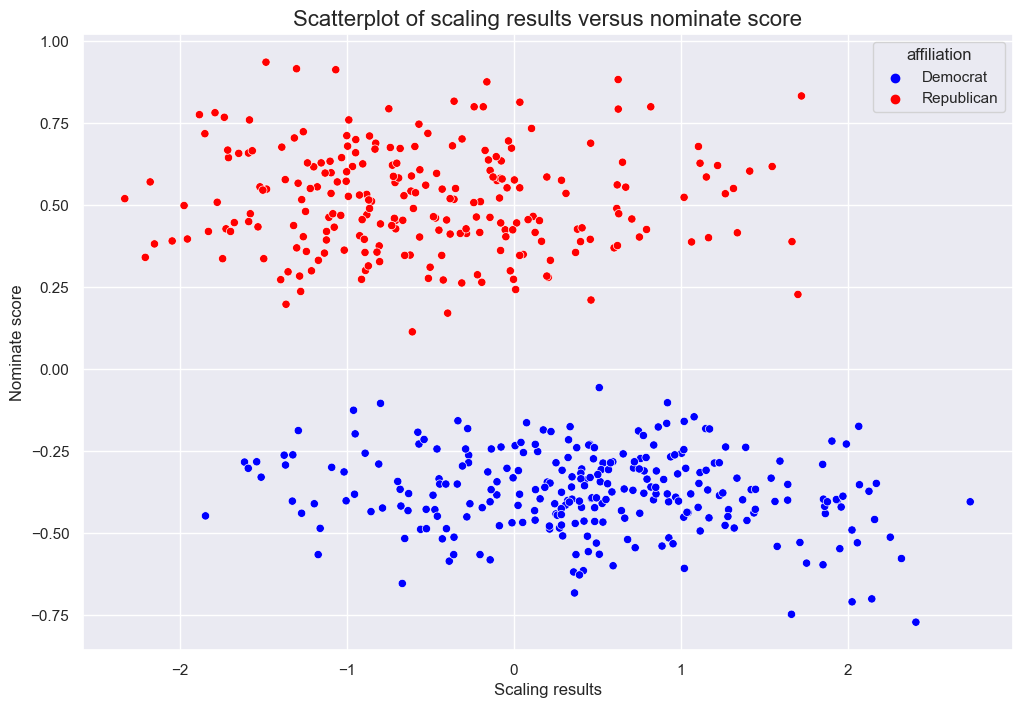

In [44]:
#Visualizing the results as a scatterplot

#Setting size of the figure and style
plt.figure(figsize = (12,8))
sns.set_theme(style="darkgrid")

#Defining colors
palette = ['Blue','Red']

#Plotting the scatterplot
sns.scatterplot(x = 'scaling_results', y = 'nominate_score', hue = 'affiliation', data = tweets_agg, palette = palette)

#Setting title and axis labels
plt.title('Scatterplot of scaling results versus nominate score', fontsize = 16)
plt.xlabel('Scaling results')
plt.ylabel('Nominate score')

plt.show()


#### 4.3 Correlations within the Senate and House, respectively

In [45]:
#Separating House and Senate into two new dataframes 
house = tweets_agg.loc[tweets_agg.role == 'House']
senate = tweets_agg.loc[tweets_agg.role == 'Senate']

#Running correlations within each congressional institutions between the scaling results and the nominate scores
r, p = scipy.stats.pearsonr(house['nominate_score'], house['scaling_results'])
print('House correlation: ',r,p)

r, p = scipy.stats.pearsonr(senate['nominate_score'], senate['scaling_results'])
print('Senate correlation: ',r,p)

House correlation:  -0.5184168691488892 4.960496260151851e-29
Senate correlation:  -0.5215570322804636 3.655100937229874e-08


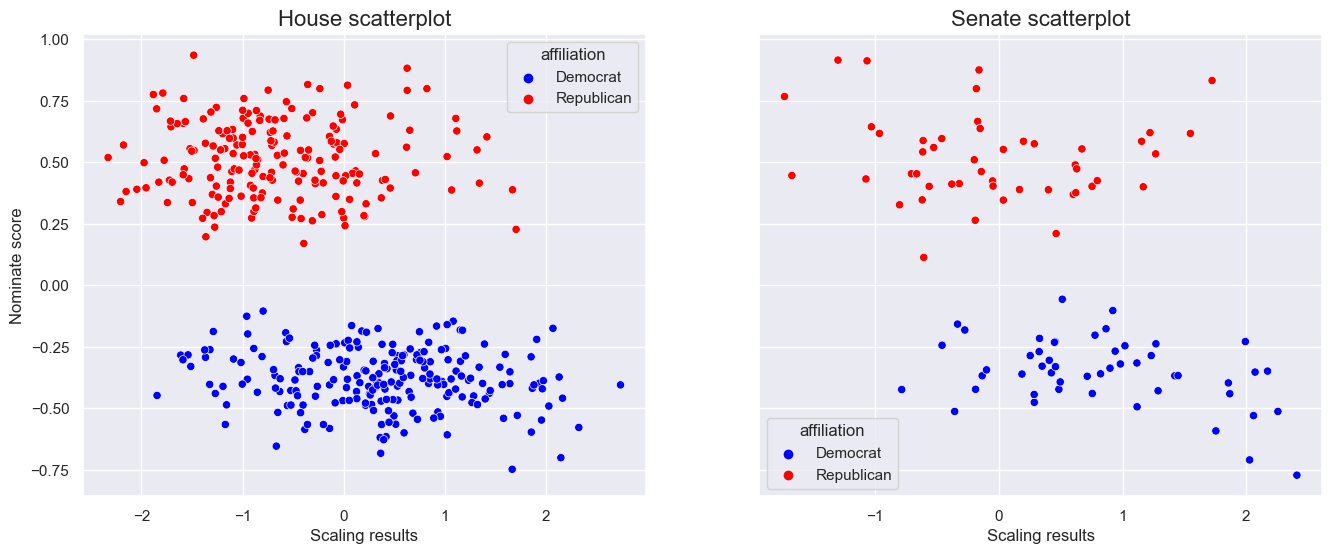

In [46]:
#Visualizing the correlations for each institution as scatterplots 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6), sharey = True)

palette = ['Blue','Red']

sns.scatterplot(ax=ax1, x='scaling_results', y='nominate_score', hue = 'affiliation', data = house, palette = palette)
ax1.set_title('House scatterplot', fontsize = 16)
ax1.set_ylabel('Nominate score')
ax1.set_xlabel('Scaling results')

sns.scatterplot(ax=ax2, x='scaling_results', y='nominate_score', hue = 'affiliation', data = senate, palette = palette)
ax2.set_title('Senate scatterplot', fontsize = 16)
ax2.set_xlabel('Scaling results')

plt.show()

#### 4.4 Correlations within the two parties

In [47]:
#Separating Democrats and Republicans into two new dataframes 
republican = tweets_agg.loc[tweets_agg.affiliation == 'Republican']
democrat = tweets_agg.loc[tweets_agg.affiliation == 'Democrat']

#Running correlations within each party between the scaling results and the nominate scores
r, p = scipy.stats.pearsonr(republican['nominate_score'], republican['scaling_results'])
print('Republican correlation: ',r,p)

r, p = scipy.stats.pearsonr(democrat['nominate_score'], democrat['scaling_results'])
print('Democrat correlation: ',r,p)

Republican correlation:  -0.03111231300266386 0.6358615580308042
Democrat correlation:  -0.16653139140279705 0.006483145270700586


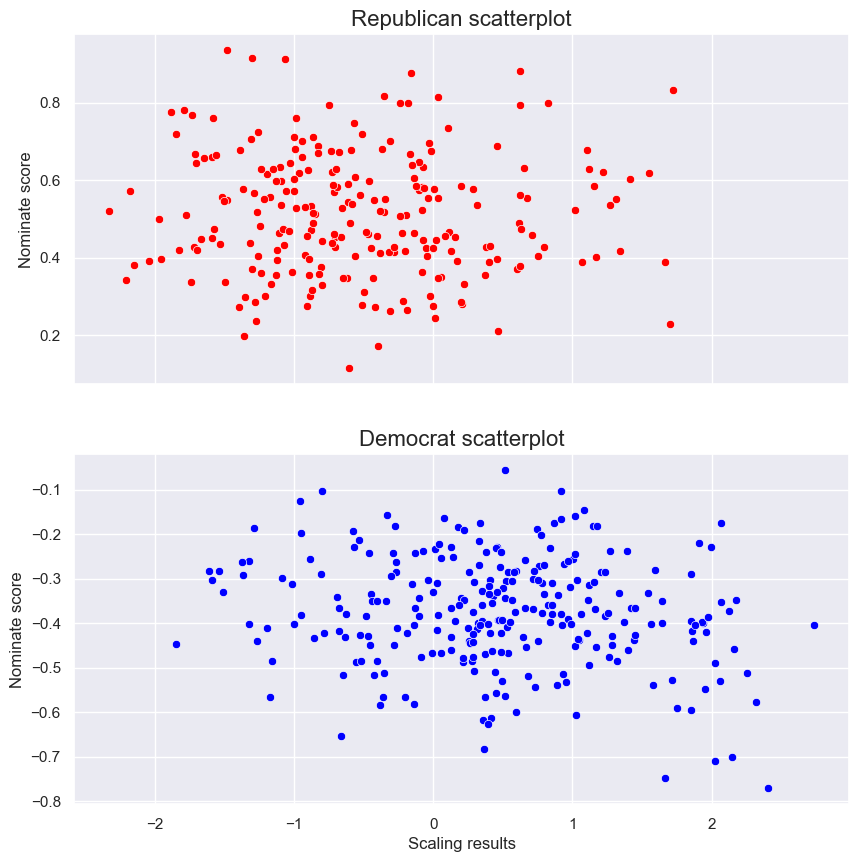

In [48]:
#Visualizing the correlations for each party as scatterplots 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,10), sharex = True)

sns.scatterplot(ax=ax1, x='scaling_results', y='nominate_score', data = republican, color = 'red')
ax1.set_title('Republican scatterplot', fontsize = 16)
ax1.set_ylabel('Nominate score')
ax1.set_xlabel('Scaling results')

sns.scatterplot(ax=ax2, x='scaling_results', y='nominate_score', data = democrat, color = 'blue')
ax2.set_title('Democrat scatterplot', fontsize = 16)
ax2.set_ylabel('Nominate score')
ax2.set_xlabel('Scaling results')

plt.show()

#### 4.5 Scores for specific politicians

In [49]:
#Finding the scaling results for Bernie Sanders and Ted Cruz 

#This code locates the row that contains the politicians' last names, and finds the wordfish result in that row

print('Bernie Sanders scaling result: \t',
      tweets_agg.loc[tweets_agg['nominate_name'].str.contains('SANDERS') == True]['scaling_results'].values[0])

print('Ted Cruz scaling result: \t', 
      tweets_agg.loc[tweets_agg['nominate_name'].str.contains('CRUZ') == True]['scaling_results'].values[0])


#Knowing these politicians, the score for Bernie Sanders seems plausible, 
#   but the score for Ted Cruz is very misleading. 
#   The wordfish scaler seems to be failing to categorize Cruz correctly.


Bernie Sanders scaling result: 	 2.0586035
Ted Cruz scaling result: 	 1.7237003


#### 4.6.1 Most extreme Republican and Democrat

In [50]:
#The code 'idxmax()' locates the index placement of the largest value in the given column


#Most extreme Republican by nominate score
print('Most extreme Republican by nominate score:',
      tweets_agg.loc[tweets_agg.nominate_score.idxmax(), 'nominate_name'],
      '-- nominate score:',
      tweets_agg.loc[tweets_agg.nominate_score.idxmax(), 'nominate_score'])

#Most extreme Republican by scaling results
print('Most extreme Republican by scaling results:',
      tweets_agg.loc[tweets_agg.scaling_results.idxmin(), 'nominate_name'],
      '-- scaling result:',
      tweets_agg.loc[tweets_agg.scaling_results.idxmin(), 'scaling_results'])


#Most extreme Democrat by nominate score
print('\nMost extreme Democrat by nominate score:',
      tweets_agg.loc[tweets_agg.nominate_score.idxmin(), 'nominate_name'],
      '-- nominate score:',
      tweets_agg.loc[tweets_agg.nominate_score.idxmin(), 'nominate_score'])

#Most extreme Democrat by scaling results
print('Most extreme Democrat by scaling results:',
      tweets_agg.loc[tweets_agg.scaling_results.idxmax(), 'nominate_name'],
      '-- scaling result:',
      tweets_agg.loc[tweets_agg.scaling_results.idxmax(), 'scaling_results'])

Most extreme Republican by nominate score: HERRELL, Yvette -- nominate score: 0.936
Most extreme Republican by scaling results: POSEY, Bill -- scaling result: -2.3285737

Most extreme Democrat by nominate score: WARREN, Elizabeth -- nominate score: -0.7709999999999999
Most extreme Democrat by scaling results: CASTEN, Sean -- scaling result: 2.734552


#### 4.6.2 Most left-wing Republican and most right-wing Democrat

In [51]:
#Here I am using the previously defined party-subsets of the dataset


#Most left-wing Republican by nominate score 
print('Most left-wing Republican by nominate score:',
      republican.loc[republican.nominate_score.idxmin(), 'nominate_name'],
      '-- nominate score:',
      republican.loc[republican.nominate_score.idxmin(), 'nominate_score'])

#Most left-wing Republican by scaling result 
print('Most left-wing Republican by scaling result:',
      republican.loc[republican.scaling_results.idxmax(), 'nominate_name'],
      '-- scaling result:',
      republican.loc[republican.scaling_results.idxmax(), 'scaling_results'])


#Most right-wing Democrat by nominate score
print('\nMost right-wing Democrat by nominate score:',
      democrat.loc[democrat.nominate_score.idxmax(), 'nominate_name'],
      '-- nominate score:',
      democrat.loc[democrat.nominate_score.idxmax(), 'nominate_score'])

#Most right-wing Democrat by scaling result
print('Most right-wing Democrat by scaling result:',
      democrat.loc[democrat.scaling_results.idxmin(), 'nominate_name'],
      '-- scaling result:',
      democrat.loc[democrat.scaling_results.idxmin(), 'scaling_results'])


Most left-wing Republican by nominate score: COLLINS, Susan Margaret -- nominate score: 0.114
Most left-wing Republican by scaling result: CRUZ, Rafael Edward (Ted) -- scaling result: 1.7237003

Most right-wing Democrat by nominate score: MANCHIN, Joe, III -- nominate score: -0.056
Most right-wing Democrat by scaling result: MFUME, Kweisi -- scaling result: -1.8451664


### Input for reflection exercise

The results of the wordfish scaler seem to not be very useful in this case. The overall correlation of approx -0.50 is a low to moderate correlation and can be acceptable. However, as there is (almost) no correlation within parties, the results are not useful in practice. 

To improve results, there may be ways to engineer the text features to support discriminating between ideologies. For instance, instead of removing URLs, one could replace URLs with the domain name being linked to (e.g. foxnews.com), which has been shown to correlate highly with ideology. 

There are algorithms implemented in R that better support ideology categorization. 
